In [1]:
import os
import re
import warnings
from collections import defaultdict
from typing import Any, Union

import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import pandas as pd
import seaborn as sn
from sklearn.metrics import accuracy_score
from yaml import safe_load
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [2]:
module_names = [x for x in "abcdefghi"]
metrics = ["Precision", "Recall", "F1 Score", "Accuracy"]

# Cross experiment comparisons

- there is a lot of data, and I find myself skimming the generated reports just to find the key metrics for comparison
- the generated data is available in raw format, so this should be automated
- on top of convenience, having raw data means we can plot it to be more easily interpretable

In [3]:
def extract_data(pattern: re.Pattern, data: str):
    return pattern.match(data).groups()


def extract_list_data(pattern: re.Pattern, data: list[str], labels: dict[int, Any] = None) -> dict[
    Union[int, str], list[str]]:
    if labels is None:
        labels = {}
    parsed_data = defaultdict(set)
    for string in data:
        if m := pattern.match(string):
            for i, parsed_val in enumerate(m.groups()):
                parsed_data[labels.get(i, i)].add(parsed_val)
    return {key: sorted(list(val)) for key, val in parsed_data.items()}


def get_param_results(in_folder, fname='param_results', **kwargs):
    param_results = pd.read_csv(f"{in_folder}/{fname}.csv", index_col=0)
    best_setting = param_results["f1"].idxmax()
    return (
        param_results.T[best_setting]
        .rename(index={"precision": "Precision", "recall": 'Recall', "f1": "F1 Score", "accuracy": "Accuracy"})
    )


def get_kfold_results(in_folder, fname1='kfold_results-ds1', fname2='kfold_results-ds2', **kwargs):
    ds1_and_extras = pd.read_csv(f"{in_folder}/{fname1}.csv", index_col=0).rename(
        columns={"DS_teorie": "D-So1", "DS#_teorie": "D-So1#", "Prioritni": "PV+", "Vetsinove": "WMV+",
                 "Oracle": "ORA+"},
    )
    ds2 = pd.read_csv(f"{in_folder}/{fname2}.csv", index_col=0)
    ds1_and_extras.insert(1, "D-So2", ds2["DS_teorie"])
    ds1_and_extras.insert(3, "D-So2#", ds2["DS#_teorie"])
    ds1_and_extras.insert(0, "", metrics)
    return ds1_and_extras.set_index("")


def get_all_results(in_folder, **kwargs):
    kfold = get_kfold_results(in_folder, **kwargs)
    ds21_opt = get_param_results(in_folder, **kwargs)
    kfold.insert(2, "D-So2.1", ds21_opt)
    return kfold


def top_stat_getter(df, metric="F1 Score"):
    return df.loc[metric, [col for col in df.columns if col != 'ORA+']].max()


def get_avg_input_acc(in_folder):
    label_results = pd.read_csv(os.path.join(in_folder, 'label_results.csv'), index_col=0)
    reference = label_results['http_ua']
    accuracies = []
    for col in label_results.columns:
        if col == 'http_ua':
            continue
        y_pred = label_results[col][label_results[col].notna()]
        y_true = reference[label_results[col].notna()]
        if len(y_true) > 0:
            accuracies.append(accuracy_score(y_true, y_pred))
    return sum(accuracies) / len(accuracies)


In [4]:
output_columns_colors = [
    ("WMV+", "tab:orange"),
    ("D-So1", "tab:purple"),
    ("D-So2", "tab:pink"),
    ("D-So2#", "tab:olive"),
    ("ORA+", "tab:gray"),
    ("DT", "darkred"),
    # ("RF", "darkred"),
    ("AB", "deeppink"),
]


def plot_results(results_df, show_acc=True, cols_sort_key=None, auto_sort=True, sort_slice=None, show_slice=None,
                 filter_cond=None, custom_columns_colors=None,
                 **kwargs):
    if cols_sort_key is None:
        cols_sort_key = lambda col: results_df[col].sum()
    if sort_slice is None:
        sort_slice = lambda x: x[:-1]
    if show_slice is None:
        show_slice = lambda x: x
    if custom_columns_colors is None:
        custom_columns_colors = output_columns_colors

    sorted_output_columns_, sorted_colors_ = sort_columns_colors(custom_columns_colors, cols_sort_key,
                                                                 filter_cond=filter_cond)
    if auto_sort:
        sorted_index_ = results_df.sort_values(by=list(reversed(sort_slice(sorted_output_columns_)))).index
    else:
        sorted_index_ = results_df.index

    plot_params = {**{'rot': 90, 'figsize': (20, 10)}, **kwargs}

    ax_ = plot_all_method_results(
        results_df.loc[sorted_index_, show_slice(sorted_output_columns_)],
        color=show_slice(sorted_colors_),
        **plot_params
    )
    if show_acc:
        ax_ = results_df.loc[sorted_index_, 'acc'].plot(ax=ax_, style='--', color='green', **plot_params)
    return ax_


def sort_columns_colors(columns_colors, by, filter_cond=None, reverse=False):
    if filter_cond is None:
        filter_cond = lambda x: True
    sorted_columns_colors = sorted(
        (
            (col, color, by(col))
            for col, color in columns_colors
            if filter_cond(col)
        ),
        key=lambda y: y[2], reverse=reverse
    )
    return [x[0] for x in sorted_columns_colors], [x[1] for x in sorted_columns_colors]


def plot_all_method_results(df, plot_index=None, **kwargs):
    if plot_index is None:
        plot_index = df.index
    ax = df.plot(**kwargs)
    plt.xticks(range(0, len(df.index)), plot_index)
    return ax


def plot_heatmap(df, title, xlabel, ylabel, figsize=(5, 5), cmap='Greens', cbar=False, square=True):
    plt.figure(figsize=figsize)
    sn.heatmap(df, annot=True, cmap=cmap, cbar=cbar, square=square)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

## Loading data

In [5]:
base_path = 'config/hourglass_out/generated_data'

uni_pattern = re.compile("full_synth_(\d)c_(\d)am_uni_(\d+)-generated-data")
variable_pattern = re.compile("full_synth_(\d)c_(\d)am_variable-generated-data")
confused_pattern = re.compile("full_synth_(\d)am_confused_(\dx\d)_(\d+)-generated-data")
split_pattern = re.compile("full_synth_(\d)am_split_(\dx\d)_(\d+)-generated-data")

directories = os.listdir(base_path)

In [6]:
extracted_uni = extract_list_data(uni_pattern, directories, {0: "class_cnt", 1: "active_modules", 2: "module_accuracy"})
top_stats = {acc: pd.DataFrame(index=extracted_uni['class_cnt'], columns=extracted_uni['active_modules'], dtype=float)
             for acc in
             extracted_uni['module_accuracy']}

extracted_var = extract_list_data(variable_pattern, directories, {0: "class_cnt", 1: "active_modules"})
top_stat_var = pd.DataFrame(index=extracted_var['class_cnt'], columns=extracted_var['active_modules'], dtype=float)

extracted_conf = extract_list_data(confused_pattern, directories, {0: "active_modules", 1: "chaos"})
top_stat_conf = pd.DataFrame(index=extracted_conf['active_modules'], columns=extracted_conf['chaos'], dtype=float)

extracted_split = extract_list_data(split_pattern, directories, {0: "active_modules", 1: "chaos"})
top_stat_split = pd.DataFrame(index=extracted_split['active_modules'], columns=extracted_split['chaos'], dtype=float)

all_results = pd.DataFrame(dtype=float)

for directory in sorted(directories):
    results = get_all_results(os.path.join(base_path, directory))
    top_f1 = top_stat_getter(results)
    all_results.loc[directory, 'acc'] = get_avg_input_acc(os.path.join(base_path, directory))

    if uni_pattern.match(directory):
        class_cnt, module_cnt, module_accuracy = extract_data(uni_pattern, directory)
        top_stats[module_accuracy].loc[class_cnt, module_cnt] = top_f1

    elif variable_pattern.match(directory):
        class_cnt, module_cnt = extract_data(variable_pattern, directory)
        top_stat_var.loc[class_cnt, module_cnt] = top_f1

    elif confused_pattern.match(directory):
        module_cnt, chaos, _ = extract_data(confused_pattern, directory)
        top_stat_conf.loc[module_cnt, chaos] = top_f1

    elif split_pattern.match(directory):
        module_cnt, chaos, _ = extract_data(split_pattern, directory)
        top_stat_split.loc[module_cnt, chaos] = top_f1

    f1_results = results.loc["F1 Score", :]
    for index, val in f1_results.items():
        all_results.loc[directory, index] = val

### More variable data

In [7]:
base_path = 'config/hourglass_out/variable_data'
directories = os.listdir(base_path)

extracted_var2 = extract_list_data(variable_pattern, directories, {0: "class_cnt", 1: "active_modules"})
top_stat_var2 = pd.DataFrame(index=extracted_var['class_cnt'], columns=extracted_var['active_modules'], dtype=float)

var_results2 = pd.DataFrame(dtype=float)

for directory in sorted(directories):
    results = get_all_results(os.path.join(base_path, directory))
    top_f1 = top_stat_getter(results)

    if variable_pattern.match(directory):
        class_cnt, module_cnt = extract_data(variable_pattern, directory)
        top_stat_var2.loc[class_cnt, module_cnt] = top_f1
        var_results2.loc[directory, 'acc'] = get_avg_input_acc(os.path.join(base_path, directory))

    f1_results = results.loc["F1 Score", :]
    for index, val in f1_results.items():
        var_results2.loc[directory, index] = val

### Random samples data

In [8]:
base_path = 'config/hourglass_out/random_data'
directories = os.listdir(base_path)

rand_results = pd.DataFrame(dtype=float)

for directory in sorted(directories):
    results = get_all_results(os.path.join(base_path, directory))
    rand_results.loc[directory, 'acc'] = get_avg_input_acc(os.path.join(base_path, directory))

    f1_results = results.loc["F1 Score", :]
    for index, val in f1_results.items():
        rand_results.loc[directory, index] = val

## Performance heatmaps

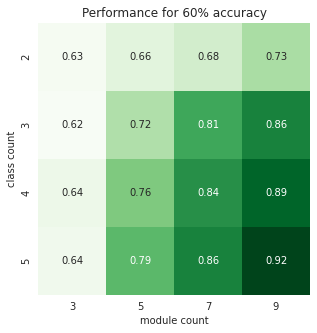

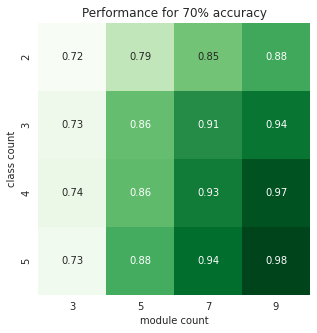

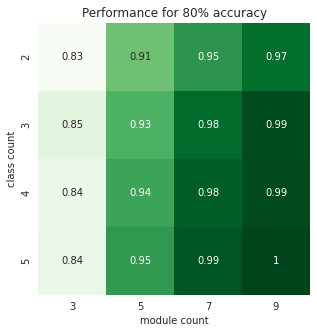

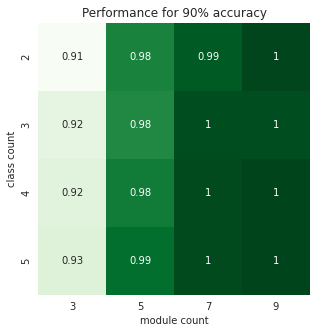

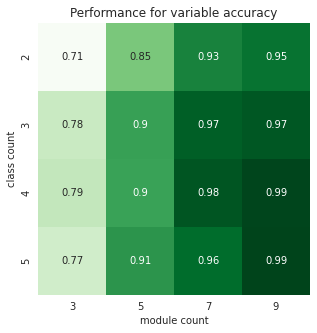

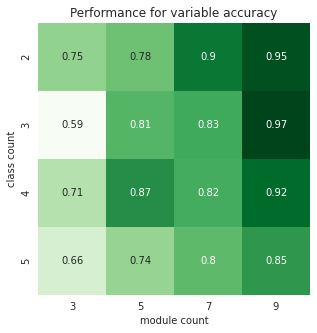

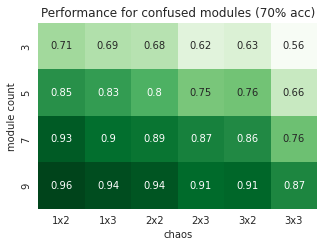

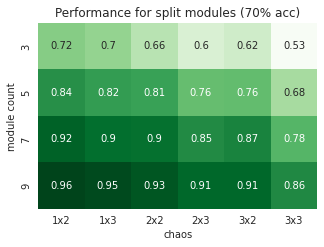

In [9]:
run_segment = True
if run_segment:
    for acc, top_stat_df in top_stats.items():
        plot_heatmap(top_stat_df, f"Performance for {acc}% accuracy", "module count", "class count")
    plot_heatmap(top_stat_var, "Performance for variable accuracy", "module count", "class count")
    plot_heatmap(top_stat_var2, "Performance for variable accuracy", "module count", "class count")
    plot_heatmap(top_stat_conf, "Performance for confused modules (70% acc)", "chaos", "module count")
    plot_heatmap(top_stat_split, "Performance for split modules (70% acc)", "chaos", "module count")

## Fusion results separated by category of experiments

In [10]:
run_segment = True

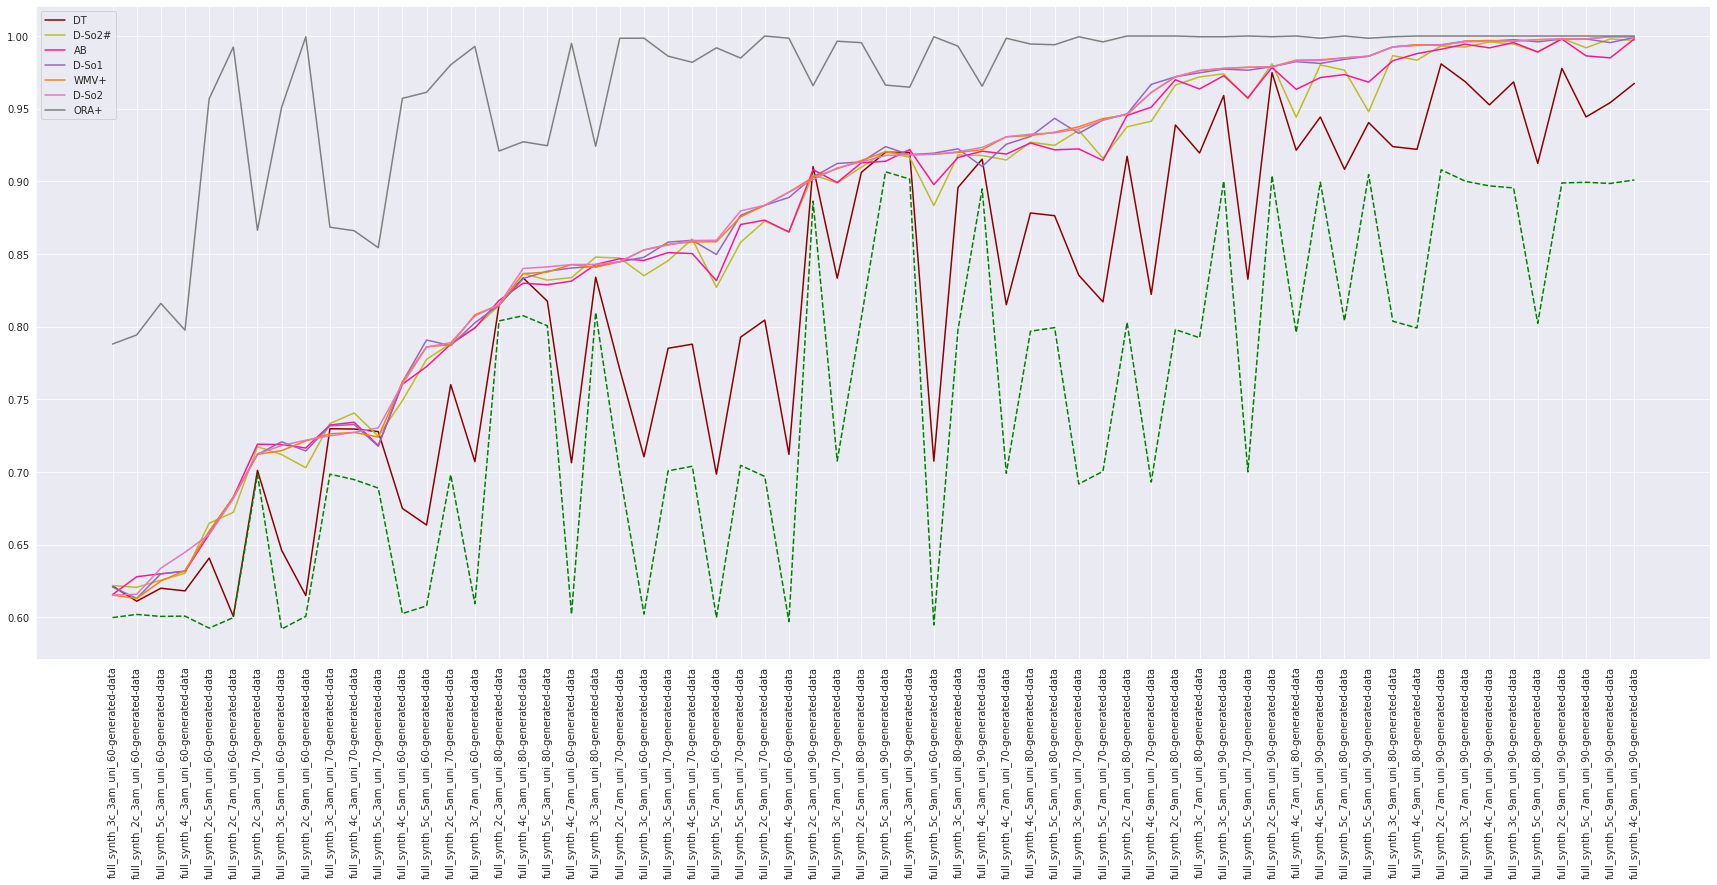

In [11]:
uni_results = all_results[all_results.index.str.contains(uni_pattern, regex=True)]
if run_segment:
    plot_results(uni_results, figsize=(30, 12))

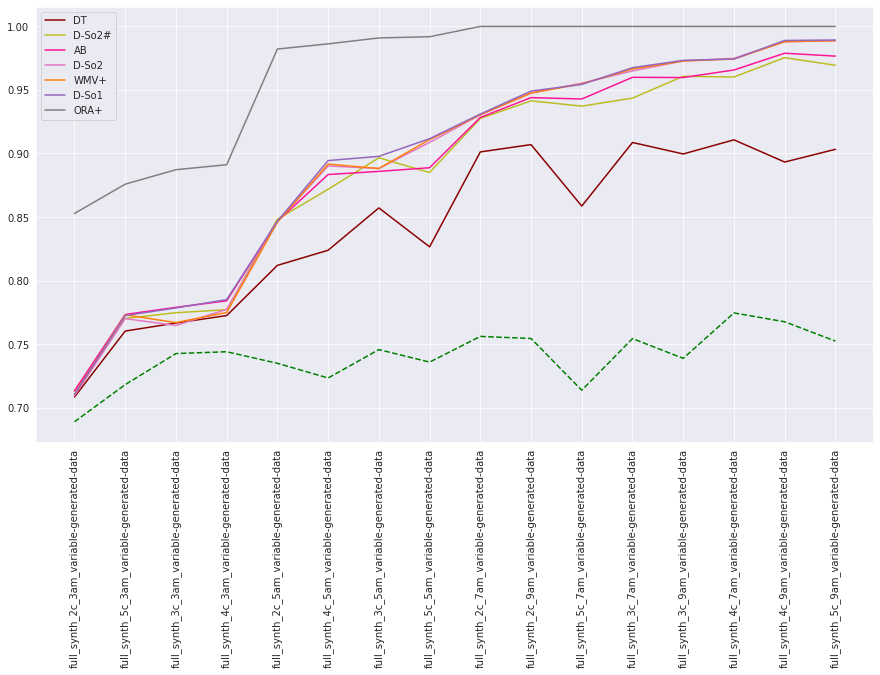

In [12]:
var_results = all_results[all_results.index.str.contains(variable_pattern, regex=True)]
if run_segment:
    plot_results(var_results, figsize=(15, 8))

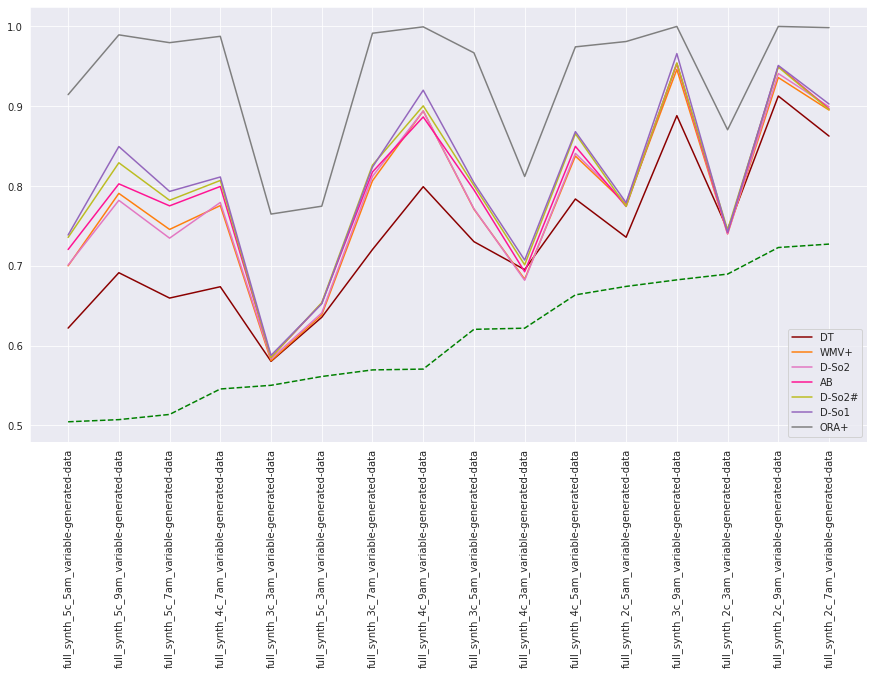

In [13]:
if run_segment:
    plot_results(var_results2.sort_values(by='acc'), auto_sort=False, figsize=(15, 8))

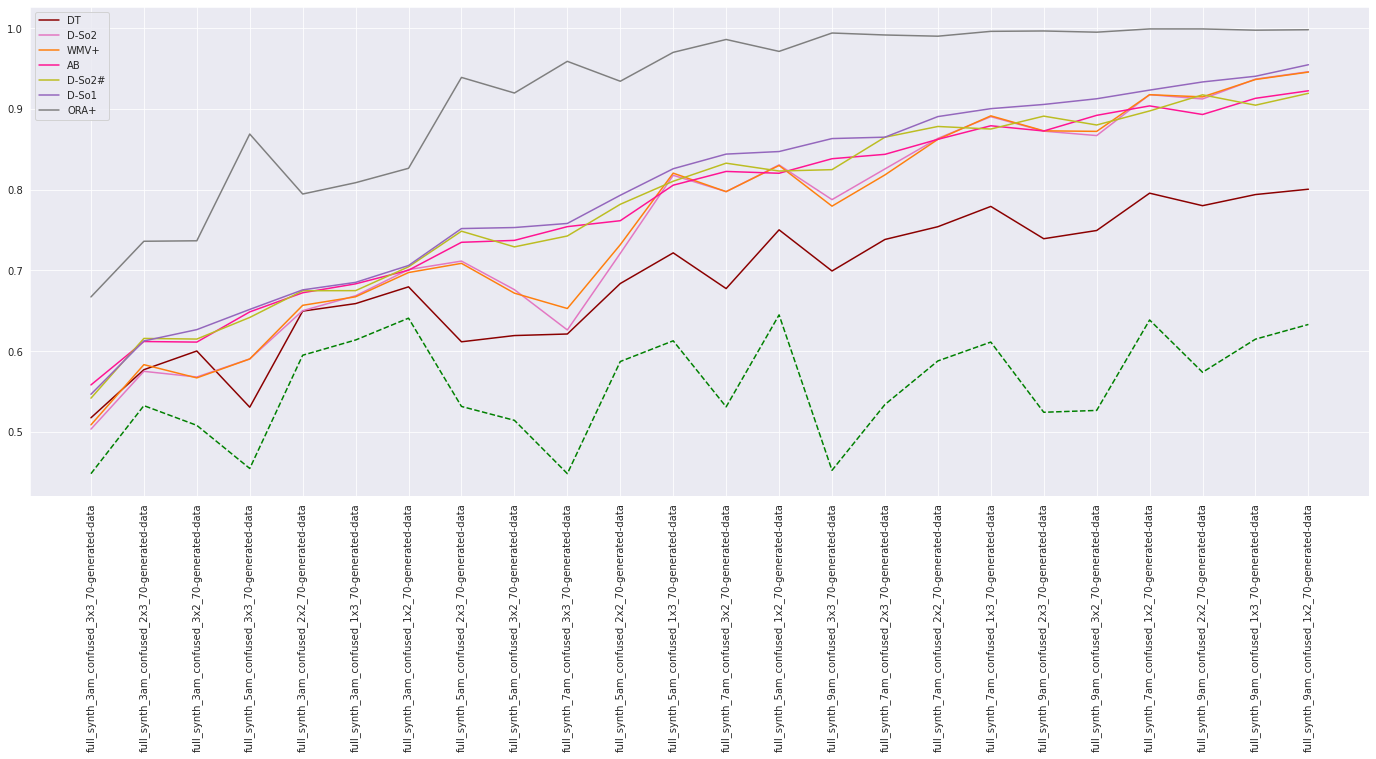

In [14]:
conf_results = all_results[all_results.index.str.contains(confused_pattern, regex=True)]
split_results = all_results[all_results.index.str.contains(split_pattern, regex=True)]
if run_segment:
    plot_results(conf_results, figsize=(24, 9))

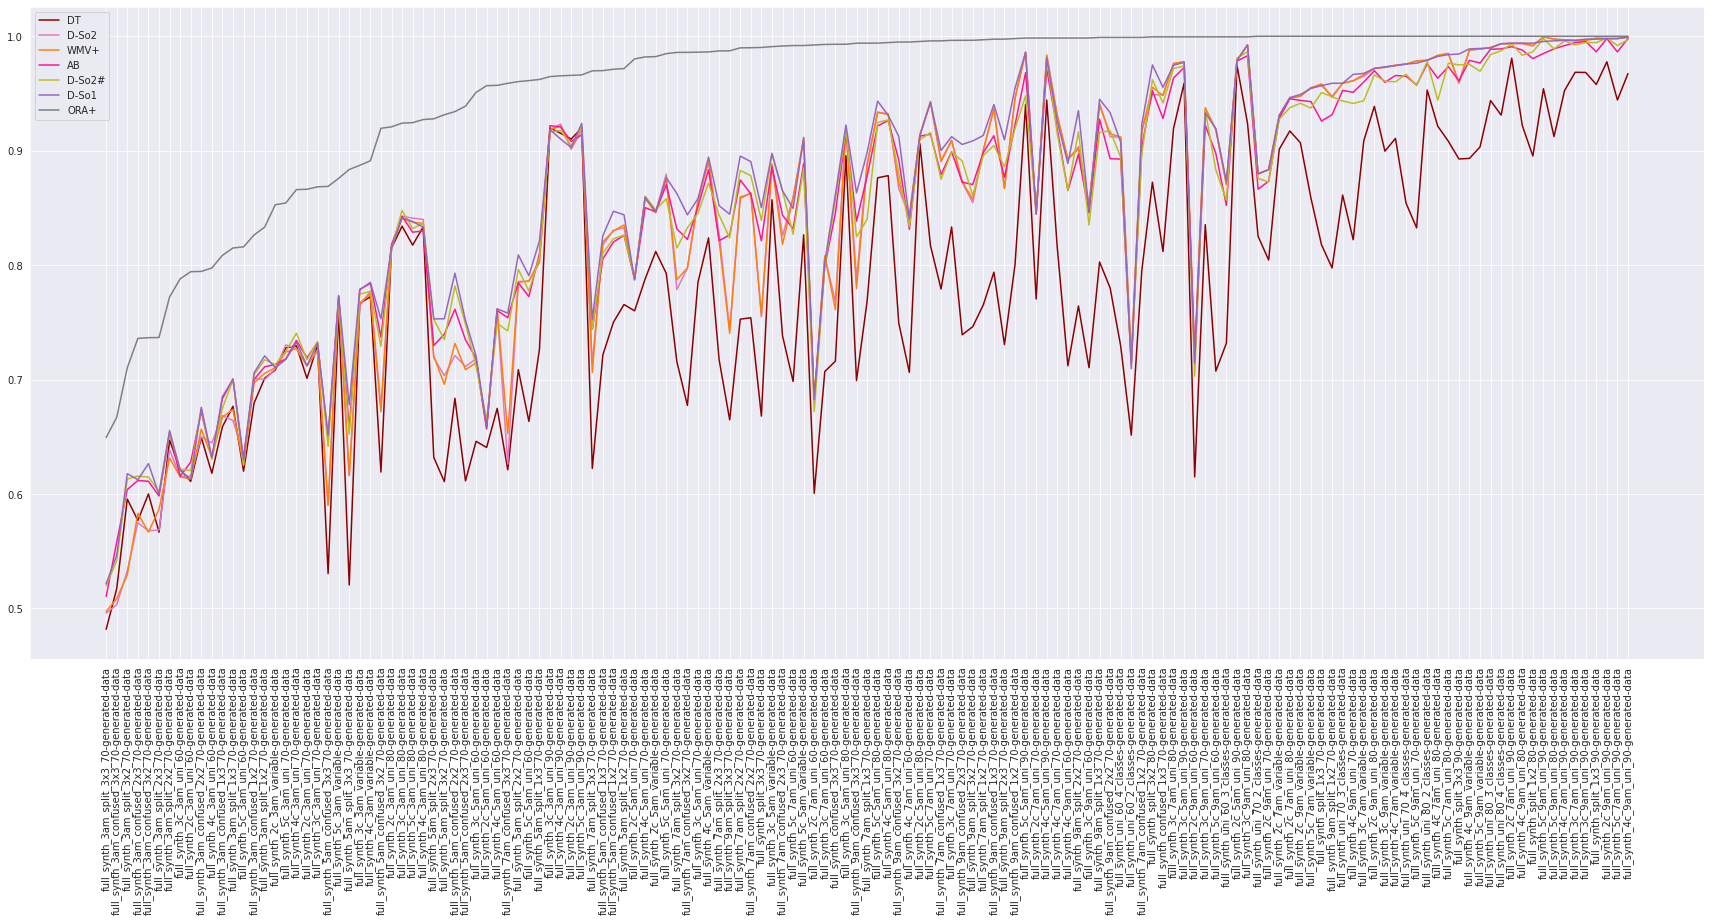

In [15]:
if run_segment:
    plot_results(all_results, sort_slice=lambda x: x, show_acc=False, figsize=(30, 12))

<AxesSubplot:>

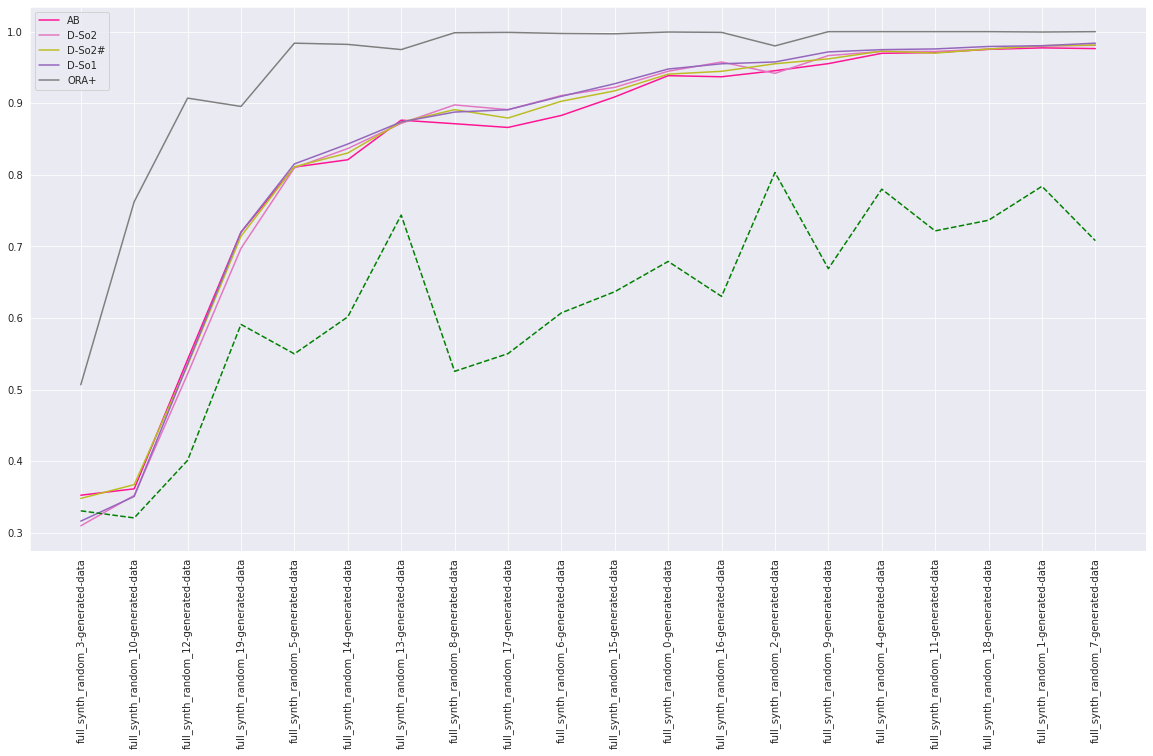

In [16]:
plot_results(rand_results, show_slice=lambda x: x[2:], sort_slice=lambda x: x[:-1])

## Normalized results against oracle + method differences against top classifier

In [17]:
run_segment = True

In [18]:
normalized_module_results = all_results.copy(deep=True)
normalized_module_results = normalized_module_results.drop(columns=["ORA+"])
normalized_module_results = normalized_module_results.divide(all_results["ORA+"], axis='index')

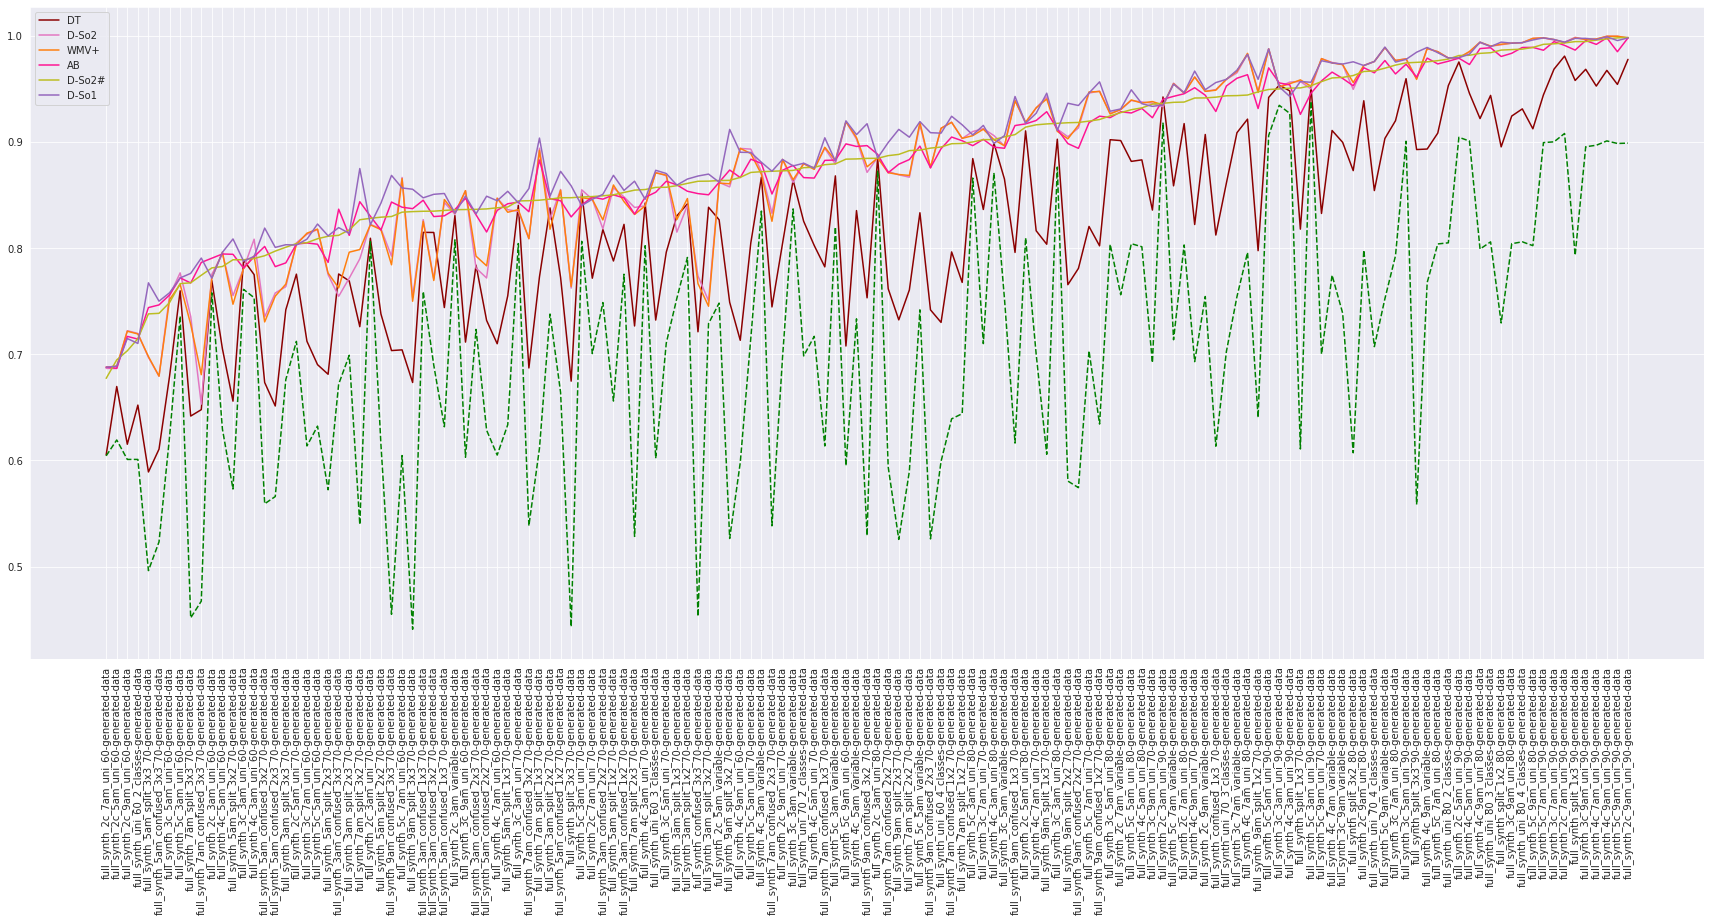

In [19]:
if run_segment:
    plot_results(normalized_module_results, filter_cond=lambda col: col != "ORA+", figsize=(30, 12))

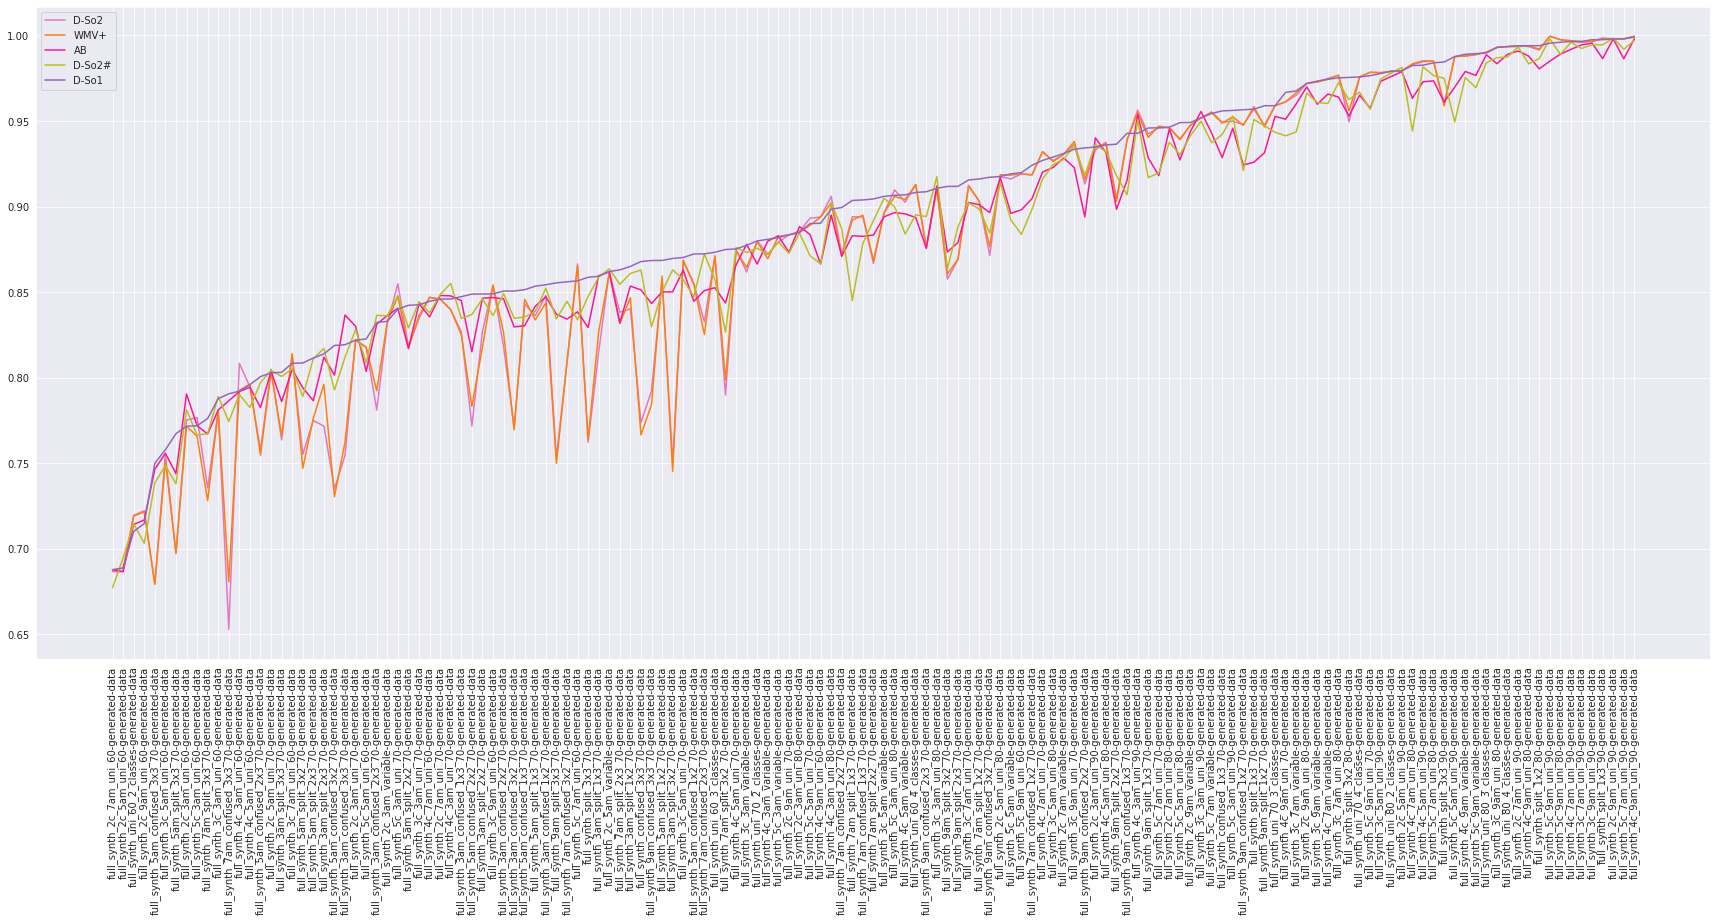

In [20]:
if run_segment:
    diff_results = normalized_module_results.copy(deep=True)
    sorted_output_columns, sorted_colors = sort_columns_colors(output_columns_colors,
                                                               lambda col: normalized_module_results[col].sum(),
                                                               filter_cond=lambda col: col != "ORA+")
    diff_df = pd.DataFrame(columns=diff_results.columns, index=diff_results.index)
    for col in diff_df:
        diff_df[col] = diff_results["NB"] - diff_results[col]

    diff_results['diff'] = abs(normalized_module_results["NB"] - normalized_module_results["D-So2.1"])
    diff_results = diff_results.sort_values(by=['D-So1', 'diff'])
    plot_all_method_results(diff_results.loc[:, sorted_output_columns[-5:]],
                            plot_index=diff_results.index,
                            figsize=(30, 12), rot=90, color=sorted_colors[-5:])

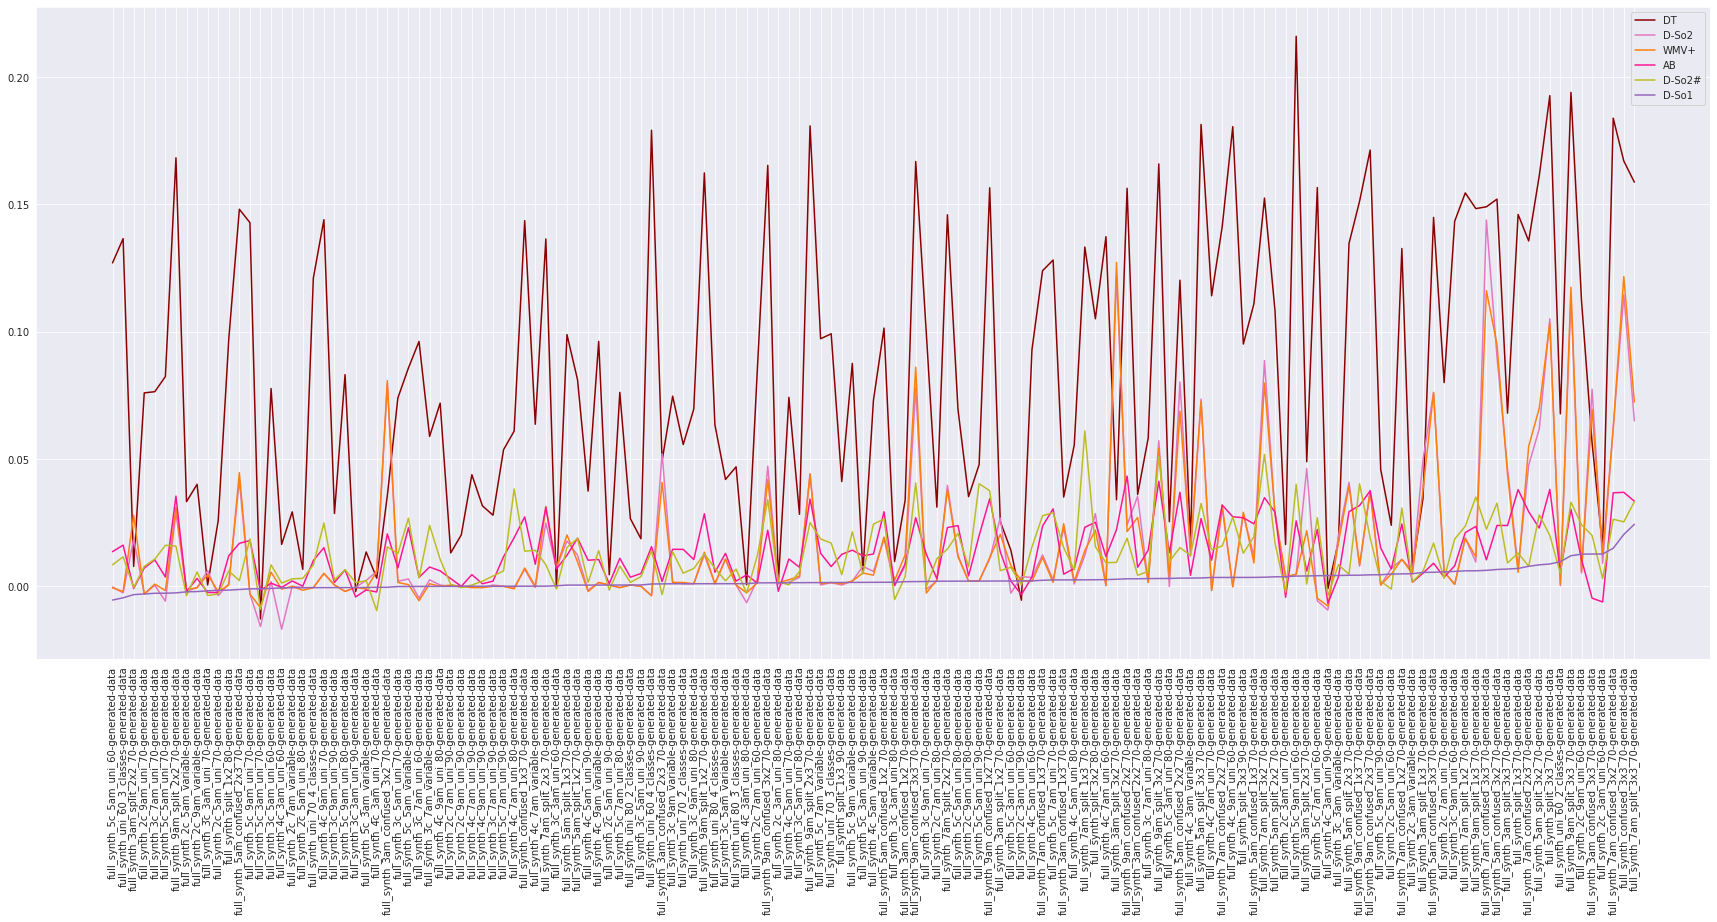

In [21]:
if run_segment:
    top_n = 6
    plot_all_method_results(
        diff_df.sort_values(by=list(reversed(sorted_output_columns))).loc[:, sorted_output_columns[-top_n:]],
        figsize=(30, 12), rot=90, color=sorted_colors[-top_n:])

## Plotting results against experiment parameters

- class count
- module count
- chaos level

In [22]:
run_segment = True

In [23]:
uni_params = all_results.index.str.extract(uni_pattern).rename(columns={0: "class_cnt", 1: "module_cnt", 2: "acc"})
var_params = all_results.index.str.extract(variable_pattern).rename(columns={0: "class_cnt", 1: "module_cnt"})
conf_params = all_results.index.str.extract(confused_pattern).rename(columns={0: "module_cnt", 1: "chaos", 2: "acc"})
split_params = all_results.index.str.extract(split_pattern).rename(columns={0: "module_cnt", 1: "chaos", 2: "acc"})

params_df = pd.DataFrame(data={
    "class_cnt": uni_params.class_cnt.fillna(var_params.class_cnt),
    "module_cnt": uni_params.module_cnt.fillna(var_params.module_cnt).fillna(conf_params.module_cnt).fillna(
        split_params.module_cnt),
    "acc": uni_params.acc.fillna(conf_params.acc).fillna(split_params.acc),
    "chaos": conf_params.chaos.fillna(split_params.chaos),
})
params_df.index = all_results.index
params_df.dropna(axis=0, how='all', inplace=True)

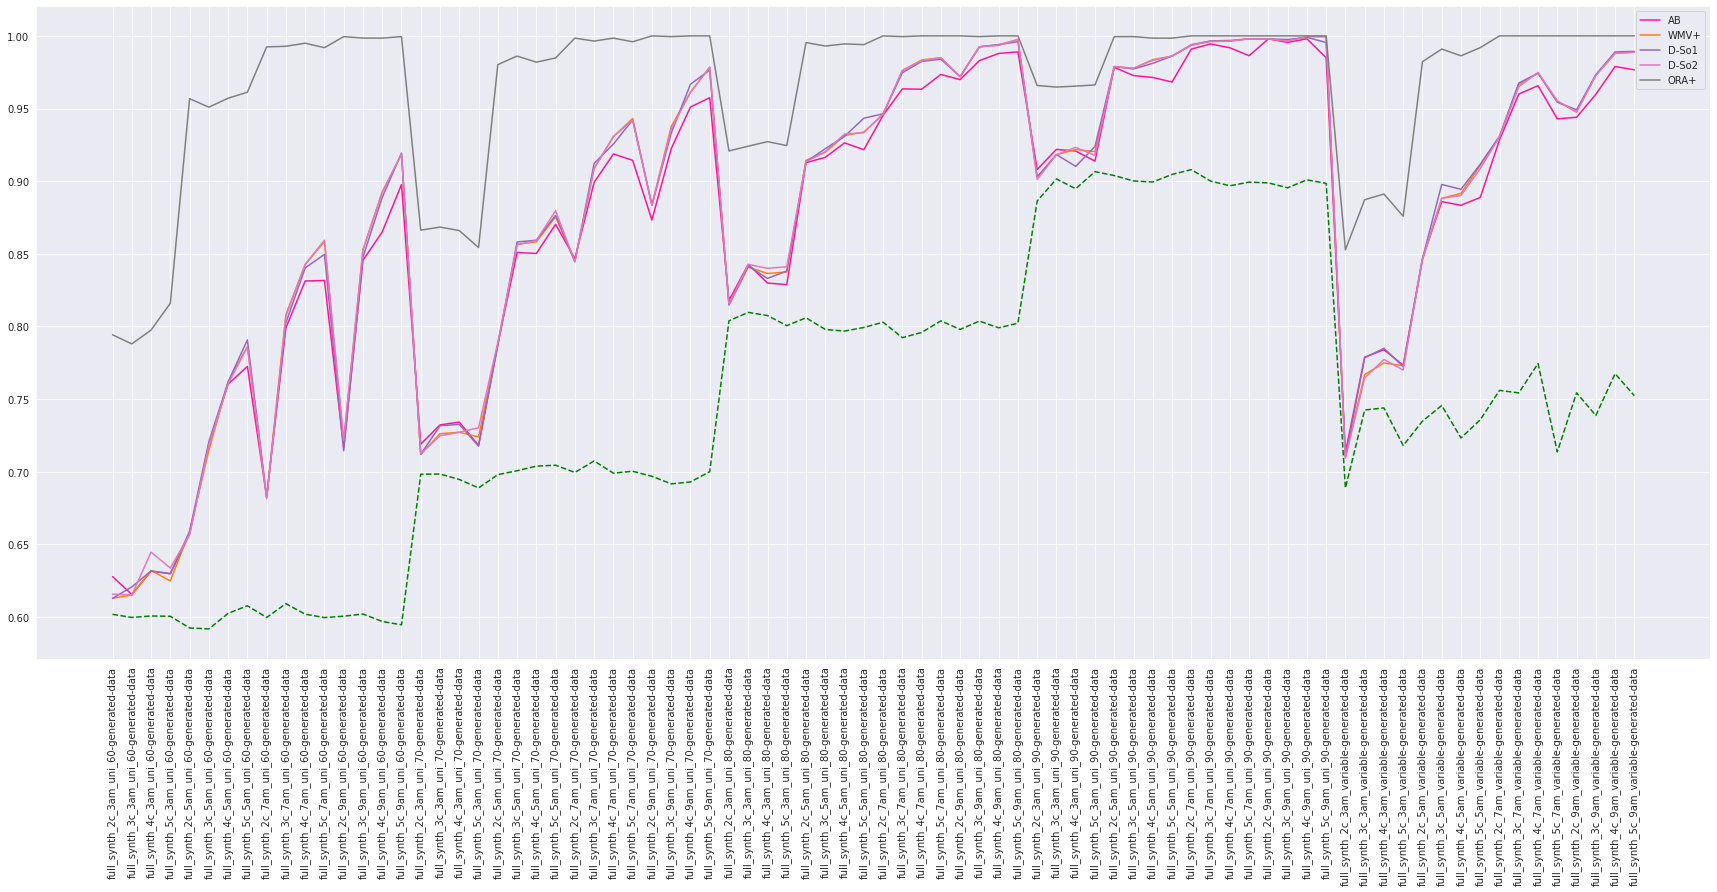

In [24]:
## Plot against module and class count
if run_segment:
    sorted_index = (
        params_df.sort_values(by=['acc', 'module_cnt', 'class_cnt'])
        [['class_cnt', 'module_cnt']]
        .dropna().index)
    plot_results(all_results.loc[sorted_index, :], auto_sort=False, figsize=(30, 12), sort_slice=lambda x: x[2:],
                 show_slice=lambda x: x[2:])

Accuracy gain at used module accuracies

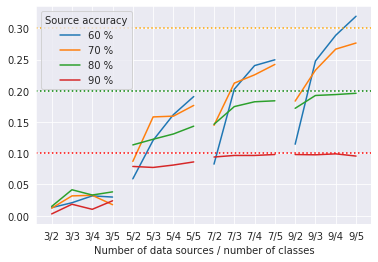

In [25]:
acc_df = pd.DataFrame()
acc_gain = pd.DataFrame()

for acc in range(60, 100, 10):
    acc_scores = all_results.loc[params_df[params_df['acc'] == str(acc)].sort_values(by=['module_cnt']).index, :][
        'D-So1']
    for i, item in acc_scores.items():
        if pd.isna(params_df.loc[i, 'class_cnt']):
            continue
        acc_df.loc[f"{params_df.loc[i, 'module_cnt']}am_{params_df.loc[i, 'class_cnt']}c", acc] = item

for acc in acc_df:
    acc_gain[acc] = acc_df[acc] - acc / 100
acc_gain.rename(index=lambda x: f'{re.match("(.)am_(.)c", x).group(1)}/{re.match("(.)am_(.)c", x).group(2)}',
                columns=lambda x: str(x) + ' %', inplace=True)
ax = acc_gain.iloc[0:4].plot(figsize=(6, 4))
for start, end in [(4,8), (8,12), (12,16)]:
    padding_df = pd.DataFrame(index=acc_gain.index, columns=acc_gain.columns)
    padding_df.iloc[start:end] = acc_gain.iloc[start:end]
    ax = padding_df.plot(ax=ax, color=["C0", "C1", "C2", "C3"], legend=False)
ax.set_xlabel("Number of data sources / number of classes")
plt.xticks(range(0, len(acc_gain.index)), acc_gain.index)
plt.axhline(y=0.1, color='r', linestyle=':')
plt.axhline(y=0.2, color='g', linestyle=':')
plt.axhline(y=0.3, color='orange', linestyle=':')
# plt.axhline(y=0.4, color='tab:blue', linestyle=':')
plt.legend(labels=acc_gain.columns, title="Source accuracy")
plt.savefig("latex/generated/accuracy_gain.pdf", bbox_inches=Bbox([[0.3,0.1],[5.85,3.54]]))
None

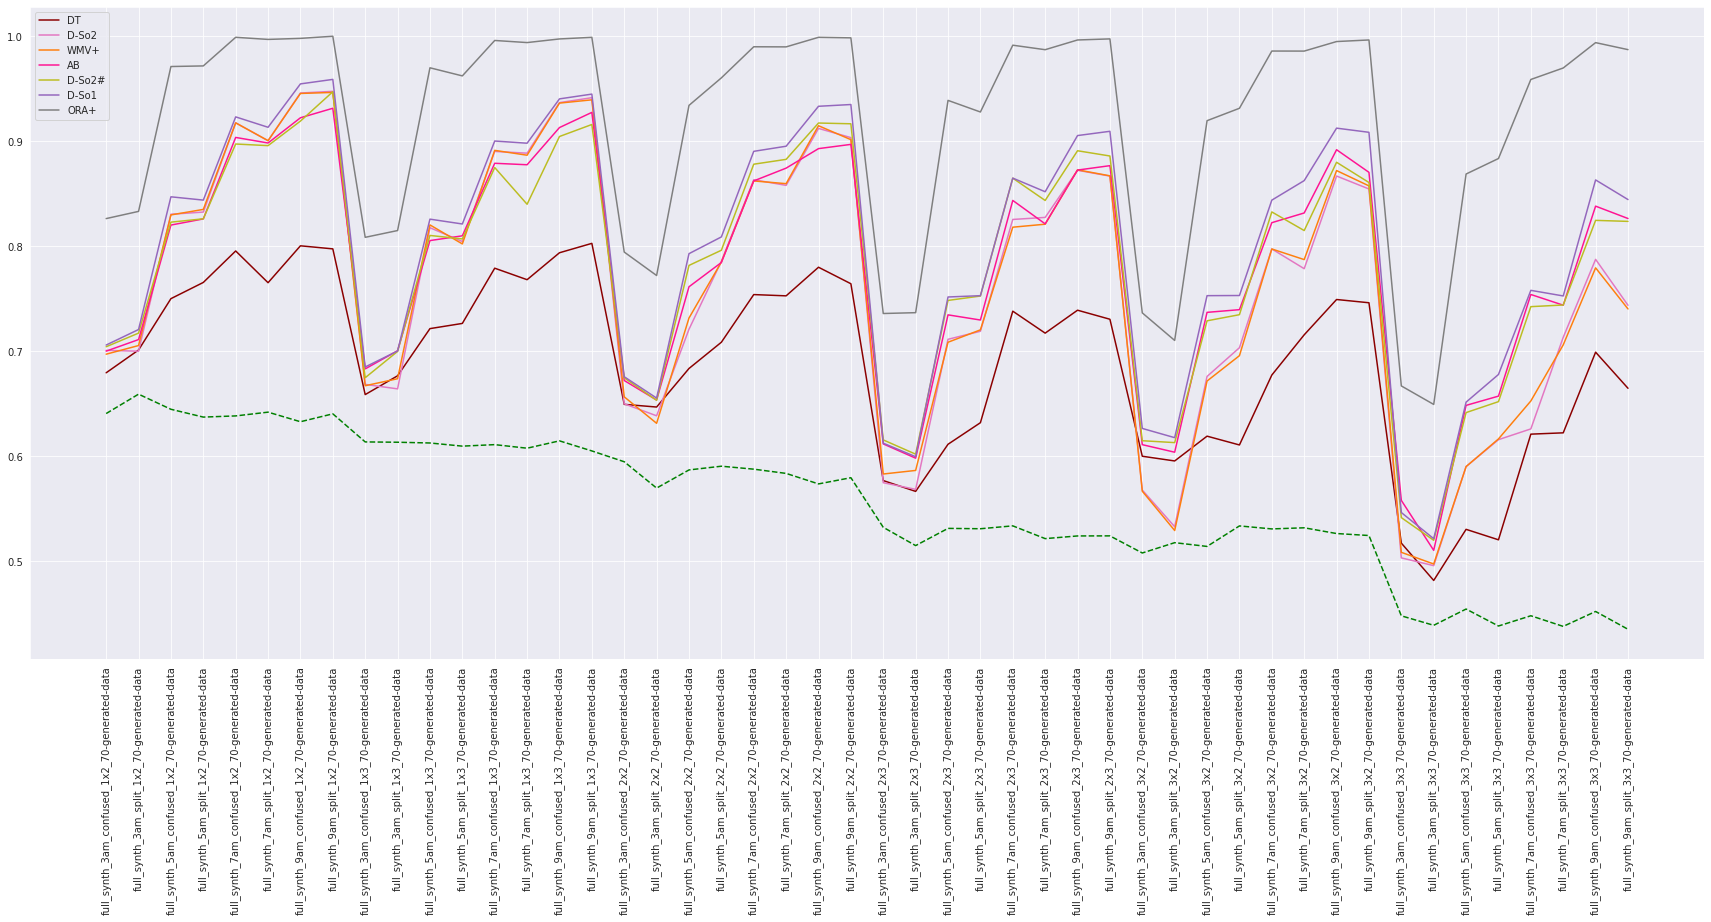

In [26]:
# plot against the chaos level
if run_segment:
    bot_skip = 0
    sorted_index = params_df.sort_values(by=['chaos', 'module_cnt'])[['chaos']].dropna().index
    plot_results(all_results.loc[sorted_index, :], auto_sort=False, figsize=(30, 12), sort_slice=lambda x: x[bot_skip:],
                 show_slice=lambda x: x[bot_skip:])
    plt.savefig("latex/generated/chaos_level_plot.jpg", bbox_inches='tight')

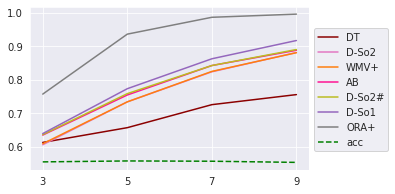

In [27]:
with_chaos = params_df.loc[params_df['chaos'].notna()]
aggregated_summary = pd.DataFrame(index=with_chaos.module_cnt.unique())
for module_cnt in aggregated_summary.index:
    score_means = all_results.loc[with_chaos[with_chaos['module_cnt'] == module_cnt].index, :].mean()
    for method, score in score_means.items():
        aggregated_summary.loc[module_cnt, method] = score
ax = plot_results(aggregated_summary, auto_sort=False, figsize=(5, 3), sort_slice=lambda x: x[bot_skip:],
             show_slice=lambda x: x[bot_skip:], rot=0)
ax.legend(bbox_to_anchor=(1, 0.9))
plt.savefig("latex/generated/chaos_level_plot2.pdf", bbox_inches='tight', dpi=300)

          acc      D-S1      D-S2   D-So2.1    D-So1#      DSGD       PV+  \
1x2  0.642003  0.858486  0.846959  0.849068  0.852114  0.841302  0.661305   
1x3  0.611031  0.839516  0.826532  0.828635  0.836240  0.815949  0.652361   
2x2  0.583383  0.823394  0.791559  0.793827  0.816567  0.812629  0.637510   
2x3  0.526708  0.781085  0.745774  0.750978  0.772122  0.775526  0.639754   
3x2  0.523442  0.784746  0.722240  0.728359  0.777972  0.760032  0.572066   
3x3  0.444250  0.702001  0.634513  0.643004  0.694622  0.686296  0.550137   

          WMV       ORA        DT        NB        RF        AB  
1x2  0.847233  0.949563  0.756920  0.860893  0.840900  0.839176  
1x3  0.827198  0.942767  0.740946  0.842725  0.821146  0.824556  
2x2  0.792869  0.929822  0.717489  0.824924  0.796272  0.799814  
2x3  0.747234  0.914029  0.664024  0.783631  0.747013  0.761116  
3x2  0.722258  0.907648  0.664290  0.789532  0.751779  0.763543  
3x3  0.636433  0.872333  0.582197  0.709989  0.666430  0.692129 

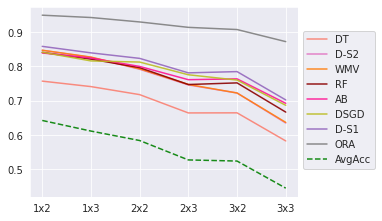

In [28]:
def plot_results(results_df, show_acc=True, cols_sort_key=None, auto_sort=True, sort_slice=None, show_slice=None,
                 filter_cond=None, custom_columns_colors=None,
                 **kwargs):
    if cols_sort_key is None:
        cols_sort_key = lambda col: results_df[col].sum()
    if sort_slice is None:
        sort_slice = lambda x: x[:-1]
    if show_slice is None:
        show_slice = lambda x: x
    if custom_columns_colors is None:
        custom_columns_colors = output_columns_colors

    sorted_output_columns_, sorted_colors_ = sort_columns_colors(custom_columns_colors, cols_sort_key,
                                                                 filter_cond=filter_cond)
    if auto_sort:
        sorted_index_ = results_df.sort_values(by=list(reversed(sort_slice(sorted_output_columns_)))).index
    else:
        sorted_index_ = results_df.index

    plot_params = {**{'rot': 90, 'figsize': (20, 10)}, **kwargs}

    ax_ = plot_all_method_results(
        results_df.loc[sorted_index_, show_slice(sorted_output_columns_)],
        color=show_slice(sorted_colors_),
        **plot_params
    )
    if show_acc:
        ax_ = results_df.loc[sorted_index_, 'acc'].plot(ax=ax_, style='--', color='green', label="AvgAcc", **plot_params)
    return ax_


with_chaos = params_df.loc[params_df['chaos'].notna()]
aggregated_summary = pd.DataFrame(index=with_chaos.chaos.unique())
for chaos in aggregated_summary.index:
    score_means = all_results.loc[with_chaos[with_chaos['chaos'] == chaos].index, :].mean()
    for method, score in score_means.items():
        aggregated_summary.loc[chaos, method] = score
aggregated_summary.rename(columns={"WMV+": "WMV", "D-So1": "D-S1", "D-So2": "D-S2", "D-So2#": "DSGD", "ORA+": "ORA"},
                          inplace=True)
print(aggregated_summary)
ax = plot_results(aggregated_summary, auto_sort=False, figsize=(4.8, 3.5), sort_slice=lambda x: x[bot_skip:],
             show_slice=lambda x: x[bot_skip:], rot=0, custom_columns_colors=[
        ("WMV", "tab:orange"),
        ("D-S1", "tab:purple"),
        ("D-S2", "tab:pink"),
        ("DSGD", "tab:olive"),
        ("ORA", "tab:gray"),
        ("DT", "salmon"),
        ("RF", "darkred"),
        ("AB", "deeppink"),
    ], alpha=0.9)
ax.legend(bbox_to_anchor=(1, 0.9))
plt.savefig("latex/generated/chaos_level_plot3.pdf", bbox_inches=Bbox([[0.25,0.2],[5.6,3.1]]), dpi=300)

## Overall method results

Average score of methods over all experiments

In [29]:
comparable_results = all_results.loc[params_df[(params_df.acc == '70') | params_df.acc.isna()].index, :]

In [30]:
average_df = pd.DataFrame(index=all_results.columns)
for label, df in [('all', all_results), ('comparable', comparable_results), ('random', rand_results),
                  ('uni', uni_results), ('variable', var_results), ('variable2', var_results2),
                  ('confused', conf_results), ('split', split_results)]:
    average_df[label] = df.sum() / len(df)
average_df.sort_values(by='comparable', ascending=False)

,all,comparable,random,uni,variable,variable2,confused,split
ORA+,0.954929,0.937056,0.949148,0.967147,0.966149,0.937833,0.919695,0.919026
NB,0.861202,0.831175,0.842941,0.877332,0.896087,0.807504,0.802234,0.801664
D-So1,0.858926,0.828720,0.839824,0.876004,0.895291,0.806121,0.798535,0.797875
D-So1#,0.854677,0.823433,0.838144,0.872770,0.892433,0.799895,0.792946,0.790266
D-So2#,0.848489,0.815451,0.837590,0.869346,0.884513,0.800369,0.782820,0.781091
AB,0.847900,0.814986,0.832939,0.870242,0.888145,0.793437,0.780849,0.779262
D-So2.1,0.847251,0.808928,0.839991,0.877736,0.893241,0.788640,0.765679,0.765611
RF,0.842262,0.806804,0.827262,0.865371,0.882285,0.781540,0.770780,0.770400
WMV+,0.845229,0.806570,0.832272,0.876276,0.892808,0.782443,0.762191,0.762218
D-So2,0.845133,0.806029,0.835622,0.876871,0.892344,0.783417,0.760610,0.761916


In [31]:
heatmap_df = average_df.loc[
    [x for x in average_df.index if x not in ['acc', 'D-So2.1', 'D-So1#', 'PV+', "NB"]],
    ['uni', 'variable2', 'confused', 'random']
].sort_values(by='random', ascending=False)
heatmap_df.rename(columns={"uni": "Uniform", "variable2": "Variable", "confused": "Faults", "comparable": "Comparable",
                           "random": "Random"},
                  index={"WMV+": "WMV", "D-So1": "D-S1", "D-So2": "D-S2", "D-So2#": "DSGD", "ORA+": "ORA"},
                  inplace=True)

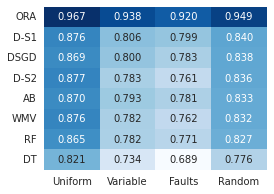

In [32]:
plt.figure(figsize=(4, 3))
sn.heatmap(
    heatmap_df,
    annot=True,
    cmap='Blues',
    square=False,
    fmt='.3f',
    cbar=False,
)
plt.savefig("latex/generated/method_comparison_plot.pdf", bbox_inches=Bbox([[0.0,0.16],[4.15,2.65]]))

## Individual method ordering

In [33]:
run_segment = False

In [34]:
sorted_output_columns, sorted_colors = sort_columns_colors(output_columns_colors,
                                                           lambda col: all_results[col].sum())
method_order = pd.DataFrame(
    {col: all_results[sorted_output_columns].sort_values(by=[col], ascending=False).index
     for col in all_results.columns if col not in  ['acc', 'D-So2.1', 'D-So1#', 'PV+', "NB", "RF"]})

In [35]:
experiment_ranking = pd.DataFrame(index=all_results.index, columns=all_results.columns, dtype=float)
for i, row in method_order.iterrows():
    for col, item in row.items():
        experiment_ranking.loc[item, col] = i
experiment_ranking = experiment_ranking.sort_values(by=list(reversed(sorted_output_columns[:-1])))[
    sorted_output_columns]

In [36]:
if run_segment:
    selector = experiment_ranking['ORA+'].notna()
    # selector = experiment_ranking.index.str.contains(variable_pattern, regex=True)

    plt.figure(figsize=(10, selector.sum() / 2.8))
    sn.heatmap(experiment_ranking[selector], annot=True, cmap='Blues', cbar=False, square=False, fmt='g')

## Distortion resilience testing


In [37]:
base_path = 'config/hourglass_out/distortion_resilience'
directories = sorted(os.listdir(base_path))
dist_test_results = pd.DataFrame(dtype=float)

for directory in directories:
    results = get_all_results(os.path.join(base_path, directory), fname='param_dr_results',
                              fname1='kfold_dr_results-ds1', fname2='kfold_dr_results-ds2')
    # top_f1 = top_stat_getter(results)

    f1_results = results.loc["F1 Score", :]
    for index, val in f1_results.items():
        dist_test_results.loc[directory, index] = val

In [38]:
dist_ref_results = pd.DataFrame(index=dist_test_results.index, columns=dist_test_results.columns)

for directory in directories:
    dir_path = os.path.join(base_path, directory)
    config_name = [config for config in os.listdir(dir_path) if config.endswith('.yml')][0]
    with open(os.path.join(dir_path, config_name), 'r') as config:
        ref = safe_load(config)['test_source']
    for col in dist_ref_results.columns:
        dist_ref_results.loc[directory, col] = all_results.loc[f"{ref}-generated-data", col]

In [39]:
dist_results_diff = (dist_ref_results - dist_test_results)
dist_results_diff.sum().sort_values() / len(dist_results_diff)

ORA+       0.000793
WMV+       0.016246
D-So2      0.017792
D-So2.1     0.02141
D-So2#      0.03783
D-So1      0.044167
D-So1#     0.044167
NB         0.047094
RF         0.048864
AB         0.060883
PV+        0.066259
DT         0.081616
dtype: object

<AxesSubplot:>

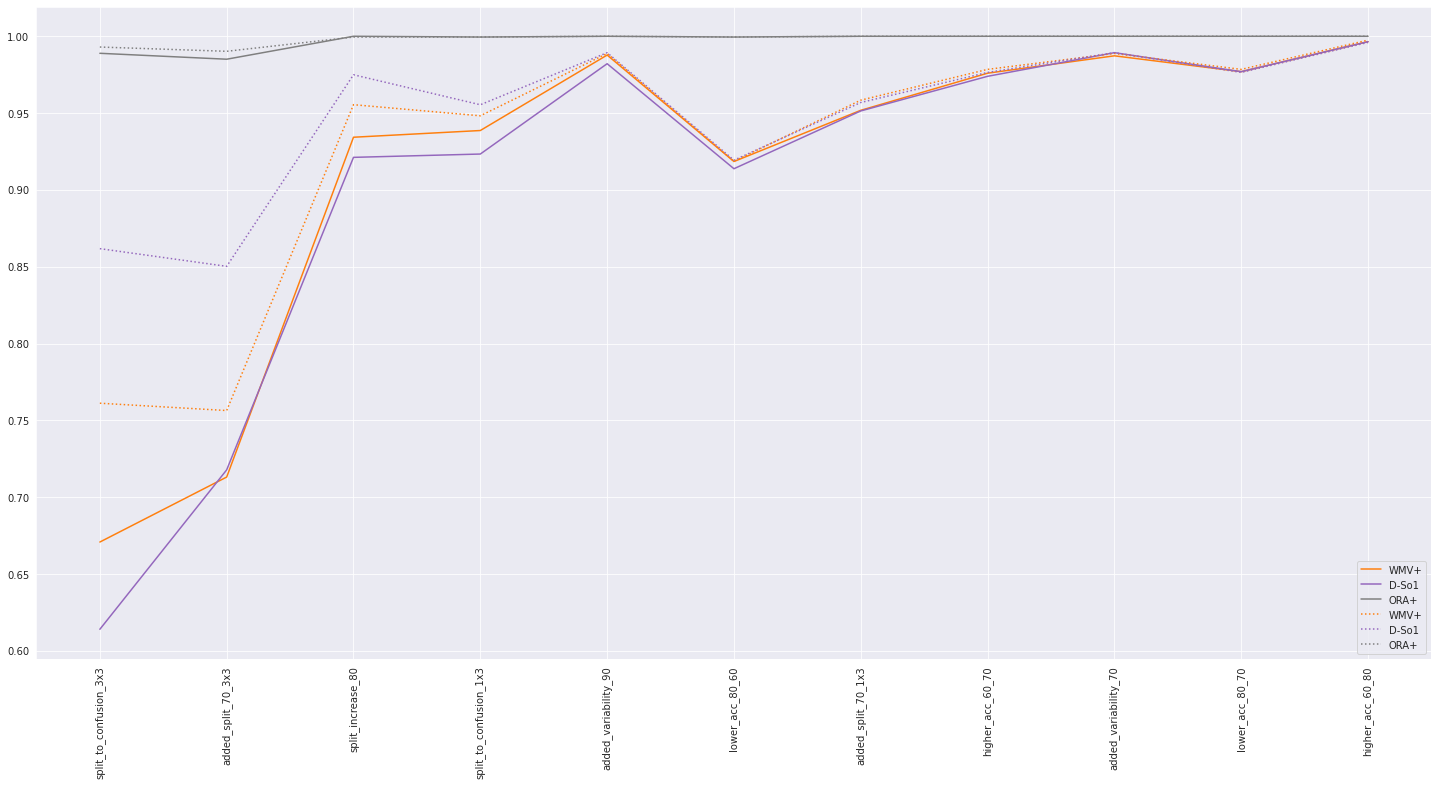

In [40]:
skip_n = 0
output_columns_subset = [
    # "PV+",
    # "DT",
    # "AB",
    # "D-So2",
    "WMV+",
    # "D-So2.1",
    # "D-So2#",
    # "RF",
    "D-So1",
    # "D-So1#",
    "NB",
    "ORA+",
]

sorted_output_columns, sorted_colors = sort_columns_colors(output_columns_colors,
                                                           lambda col: dist_ref_results[col].sum(),
                                                           filter_cond=lambda col: col in output_columns_subset,
                                                           reverse=False)
index = dist_results_diff.sort_values(by=list(reversed(sorted_output_columns))[1:], ascending=False).index
ax = plot_all_method_results(dist_test_results.loc[index, sorted_output_columns[skip_n:]],
                             plot_index=index,
                             color=sorted_colors[skip_n:])
plot_all_method_results(dist_ref_results.loc[index, sorted_output_columns[skip_n:]],
                        plot_index=index,
                        figsize=(25, 12),
                        rot=90,
                        color=sorted_colors[skip_n:],
                        ax=ax,
                        style=[':' for _ in range(len(sorted_colors[skip_n:]))])

In [41]:
dist_results_diff.sort_values(by=list(reversed(sorted_output_columns))[1:], ascending=False)[sorted_output_columns]

,WMV+,D-So1,ORA+
split_to_confusion_3x3,0.090361,0.247748,0.004074
added_split_70_3x3,0.043292,0.132468,0.005153
split_increase_80,0.021184,0.053768,-0.000509
split_to_confusion_1x3,0.009576,0.032073,0.0
added_variability_90,0.00102,0.007189,0.0
lower_acc_80_60,0.000156,0.005563,0.0
added_split_70_1x3,0.006605,0.005493,0.0
higher_acc_60_70,0.002487,0.002528,0.0
added_variability_70,0.001519,0.000008,0.0
lower_acc_80_70,0.001502,-0.000499,0.0
